**Tensor Contraction**

In [1]:
import numpy as np
from ncon import ncon
import opt_einsum as oe
from scipy.stats import unitary_group
import scipy.sparse as sp
from scipy.sparse.linalg import LinearOperator, eigsh
from itertools import combinations
import matplotlib.pyplot as plt

# Tensor Contraction

<img src="figure/tn_1.png" width="500" />

reprinted from "https://www.tensors.net/section-1"

In [2]:
# Define some dummy tensors for demonstration
d = 10
A = np.random.rand(d,d,d)
B = np.random.rand(d,d,d,d)
C = np.random.rand(d,d,d)
D = np.random.rand(d,d)


# Method 1: ncon 
TensorArray = [A, B, C, D]
IndexArray = [[1, -2, 2], [-1, 1, 3, 4], [5, 3, 2], [4, 5]]
E_ncon = ncon(TensorArray, IndexArray, order=[5, 3, 4, 1, 2])

# Method 2: opt_einsum.contract.() /
#           np.einsum(..., optimize='optimal')


CD = oe.contract('ecb,de->dcb', C, D)        # Contract index 5     (use np.tensordot() for 2 tensors)
BCD = oe.contract('iacd,dcb->iab', B, CD)    # Contract indices 3,4
ABCD = oe.contract('ajb,iab->ijb', A, BCD)   # Contract index 1
E_einsum = oe.contract('ijb->ij', ABCD)      # Contract index 2 (trace)

E_simple_einsum = oe.contract('ajb,iacd,ecb,de->ij', A, B, C, D,  optimize='auto')

assert np.allclose(E_ncon, E_einsum, E_simple_einsum)

# Tensor Decomposition

### Frobenius norm

To approximate a higher-order tensor as a product of lower-order tensors, we need a tensor norm to **measure the performance** of the approximation.

Given a tensor $A_{i j k \dots}$, the Frobenius norm is
$$
||A||_F = \sqrt{\sum_{i j k \dots} |A_{i j k \dots}|^2}.
$$
Equivalently, it is the square root of the full contraction with its conjugate:
$$
||A||_F^2 = \langle A, A \rangle
= \sum_{i j k \dots} A^*_{i j k \dots} A_{i j k \dots}.
$$
(For a matrix $A$, this reduces to $||A||_F^2 = \mathrm{Tr}(A^\dagger A)$.)

<img src="figure/tn_2.png" width="500" />

Reprinted from https://www.tensors.net/tutorial-2


### 1.1 Spectral Decomposition (Eigendecomposition)

For a $d \times d$ Hermitian matrix $H$:

$$
H = U D U^\dagger,
$$

where:
- $U$ is a $d \times d$ unitary matrix ($U^\dagger U = U U^\dagger = I$)
- $D = \mathrm{diag}(\lambda_1, \lambda_2, \ldots, \lambda_d)$ is a $d\times d$ diagonal matrix of eigenvalues

**Computational Cost:** typically scales as $O(d^3)$ for dense eigendecomposition.


In [3]:
# Create Hermitian tensor
d = 2
A = np.random.rand(d, d, d, d)
H_tensor = 0.5 * (A + A.transpose(2, 3, 0, 1))

# Reshape to matrix for eigendecomposition
H_matrix = H_tensor.reshape(d*d, d*d)

# Eigendecomposition
D, U_matrix = np.linalg.eigh(H_matrix)

# Reshape U to order-3 tensor 
U_tensor = U_matrix.reshape(d, d, d*d)

# Verify: H = U @ diag(D) @ U†
# Contract to get tensor form
H_reconstructed_tensor = oe.contract('ija,a,kla->ijkl', 
                                      U_tensor, D, U_tensor.conj())

# Compare in TENSOR form
error = np.linalg.norm(H_tensor - H_reconstructed_tensor) / np.linalg.norm(H_tensor)

print(f"error: {error:.2e}")
print(f"eigenvalues: {D}")



error: 9.76e-16
eigenvalues: [-0.47133274  0.16865824  0.57038836  2.17047349]


### 1.2 SVD Decomposition

For any matrix $A$ with dimension $d_1 \times d_2$:

$$
A = U S V^\dagger.
$$

**Economical (thin) SVD:** let $r = \min(d_1,d_2)$, then
- $U$ is a $d_1 \times r$ isometry, $U^\dagger U = I_r$
- $S$ is an $r \times r$ diagonal matrix $S=\mathrm{diag}(s_1,\dots,s_r)$ with $s_1 \ge s_2 \ge \cdots \ge s_r \ge 0$
- $V$ is a $d_2 \times r$ isometry, $V^\dagger V = I_r$

**Full SVD:** $U$ is $d_1\times d_1$ unitary, $V$ is $d_2\times d_2$ unitary, and $S$ is $d_1\times d_2$ with the singular values on its diagonal.

**Computational Cost:** typically scales as $O(d_1 d_2^2)$ when $d_1 \ge d_2$ (dense SVD).


**Frobenius norm (via singular values)**

If $A$ has singular values $\{s_k\}$, then
$$
||A||_F = \sqrt{\sum_k s_k^2}.
$$

Let $A$ be reshaped into a matrix of size $d_1 \times d_2$ (for some chosen bipartition) with SVD
$$
A_{i j} = \sum_{k=1}^{r} U_{i k} s_k V^*_{k j},
\qquad r=\min(d_1,d_2),
$$
and consider approximations $B$ of (matrix) rank $r_0$.

**Eckart–Young–Mirsky theorem:** the best rank-$r_0$ approximation in Frobenius norm is obtained by truncating the SVD to the $r_0$ largest singular values:
$$
B_{i j} = \sum_{k=1}^{r_0} U_{i k} s_k V^*_{k j}.
$$

<img src="figure/tn_3.png" width="500" />

Reprinted from https://www.tensors.net/tutorial-2

The optimal truncation error is **exactly**
$$
\epsilon = ||A-B||_F = \sqrt{\sum_{k>r_0} s_k^2}.
$$


**Relationship to Spectral Decomposition**:

Let $A \in \mathbb{C}^{d_1\times d_2}$ and write its (economical) SVD
$$
A = U S V^\dagger,
$$
where $U^\dagger U = I$, $V^\dagger V = I$, and $S = \mathrm{diag}(s_1,\dots,s_r)$ with $r=\min(d_1,d_2)$.

Then
$$
A^\dagger = V S U^\dagger,
$$
and the Hermitian products are
$$
A^\dagger A = V S^2 V^\dagger,
\qquad
A A^\dagger = U S^2 U^\dagger.
$$

So the **eigenvectors** of $A^\dagger A$ are the columns of $V$, and the **eigenvectors** of $A A^\dagger$ are the columns of $U$.
In both cases, the eigenvalues are the **squares** of the singular values in $S$, i.e. $\{s_k^2\}$.


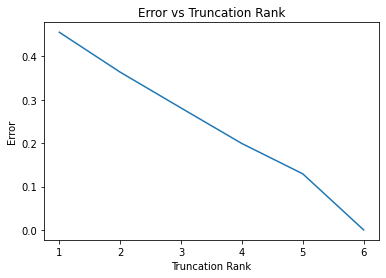

In [4]:
# High-order tensor SVD
A = np.random.rand(2, 3, 4, 5)

# Choose bipartition: {0,1} | {2,3}
d_left = A.shape[0] * A.shape[1]   # 2×3 = 6
d_right = A.shape[2] * A.shape[3]  # 4×5 = 20
A_matrix = A.reshape(d_left, d_right)


def SVD(d,A_matrix,A):
  U, S, Vh = np.linalg.svd(A_matrix, full_matrices=False)


  error = []
  for chi in range(1, d+1):
  # Truncate to chi
    U_trunc = U[:, :chi]
    S_trunc = S[:chi]
    Vh_trunc = Vh[:chi, :]


    # Reconstruct
    A_approx_matrix = U_trunc @ np.diag(S_trunc) @ Vh_trunc
    A_approx = A_approx_matrix.reshape(A.shape)

    # Error
    error.append(np.linalg.norm(A - A_approx) / np.linalg.norm(A))


  return error


# Plot error vs. truncation rank
x = range(1,d_left+1)
y = SVD(d_left,A_matrix,A)
plt.plot(x, y)

plt.title("Error vs Truncation Rank")
plt.xlabel("Truncation Rank")
plt.ylabel("Error")

plt.show()




<ipython-input-5-80f025d33df1>:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=90, ha='center', fontsize=10)


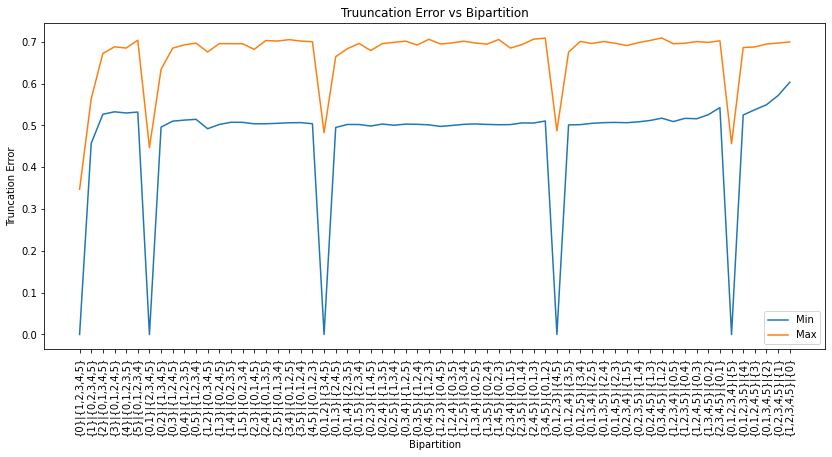

In [5]:
""" Sideway exercise exploring truncation error and type of bipartition"""

def find_all_bipartitions(n_indices):

    all_bipartitions = []

    # Consider all possible splits (at least 1 index on each side)
    for k in range(1, n_indices):
        for left_indices in combinations(range(n_indices), k):
            right_indices = [i for i in range(n_indices) if i not in left_indices]
            all_bipartitions.append((list(left_indices), list(right_indices)))

    return all_bipartitions



def compute_truncation_errors_for_bipartition(tensor, bipartition):

    shape = tensor.shape
    left_indices, right_indices = bipartition

    # Calculate dimensions for reshaping
    left_dims = [shape[i] for i in left_indices]
    right_dims = [shape[i] for i in right_indices]
    d_left = np.prod(left_dims)
    d_right = np.prod(right_dims)

    # Need to permute indices so left group comes first
    perm_order = left_indices + right_indices
    tensor_permuted = np.transpose(tensor, perm_order)

    # Reshape to matrix
    tensor_matrix = tensor_permuted.reshape(d_left, d_right)

    error = SVD(d_left,tensor_matrix,tensor)

    return error

def bipartition_to_string(bipartition):
    left, right = bipartition
    return f"{{{','.join(map(str, left))}}}|{{{','.join(map(str, right))}}}"




tensor = np.random.rand(2, 3, 4, 5, 6, 7)
d = len(tensor.shape)

truncation_error_min = []
truncation_error_max = []
for bipartition in find_all_bipartitions(d):
    truncation_error_min.append(float(np.min(compute_truncation_errors_for_bipartition(tensor, bipartition))))
    truncation_error_max.append(float(np.max(compute_truncation_errors_for_bipartition(tensor, bipartition))))



# Plot truncation error vs. bipartition
x = [bipartition_to_string(bp) for bp in find_all_bipartitions(d)]

y_min = truncation_error_min
y_max = truncation_error_max

fig, ax = plt.subplots(figsize=(14, 6))
plt.plot(x, y_min)
plt.plot(x, y_max)

plt.title("Truuncation Error vs Bipartition")
plt.xlabel("Bipartition")
plt.ylabel("Truncation Error")
plt.legend(['Min', 'Max'])
# Set x-ticks with rotated labels (90 degrees)

ax.set_xticklabels(x, rotation=90, ha='center', fontsize=10)


plt.show()

### 1.3 QR Decomposition

Reference (presentation): https://www.tensors.net/p-tutorial-2

For a $d_1 \times d_2$ matrix $A$ with $d_1 \ge d_2$:

$$
A = Q R,
$$

where:
- $Q$ is a $d_1 \times d_2$ isometry ($Q^\dagger Q = I$)
- $R$ is a $d_2 \times d_2$ upper-triangular matrix

**Computational cost:** typically scales as $O(d_1 d_2^2)$ for reduced QR.

This is the “economical” QR (vs. full QR where $Q$ is $d_1 \times d_1$ unitary and $R$ is $d_1 \times d_2$).


In [6]:
# --- Example 1: Matrix QR (economical / reduced) ---
d1, d2 = 8, 5  # d1 > d2
A = np.random.randn(d1, d2) + 1j*np.random.randn(d1, d2)

Q, R = np.linalg.qr(A, mode="reduced")   # economical: Q is (d1,d2), R is (d2,d2)

print("Matrix QR shapes:", "A", A.shape, "Q", Q.shape, "R", R.shape)
print("  relative reconstruction error ||A - Q@R|| / ||A|| =",
      np.linalg.norm(A - Q@R) / np.linalg.norm(A))

# Q is isometric: Q† Q = I
iso_err = np.linalg.norm(Q.conj().T @ Q - np.eye(d2))
print("  isometry error ||Q†Q - I|| =", iso_err)

# R should be upper-triangular (below-diagonal entries ~ 0)
below_diag = np.tril(R, k=-1)
print("  lower-triangular magnitude ||tril(R,-1)|| =", np.linalg.norm(below_diag))


# --- Example 2: Tensor QR across a chosen bipartition ---
# Order-3 tensor T(i,j,k). Choose partition (i,j) 
di, dj, dk = 3, 4, 6
T = np.random.randn(di, dj, dk) + 1j*np.random.randn(di, dj, dk)

M = T.reshape(di*dj, dk)           # reshape into a matrix across the chosen partition
Qm, Rm = np.linalg.qr(M, mode="reduced")

# Reshape Q back into an order-3 tensor (i,j,χ); R is (χ,k)
chi = Qm.shape[1]
Qt = Qm.reshape(di, dj, chi)

print("\nTensor QR (partition (i,j)|(k)) shapes:", "M", M.shape, "Qm", Qm.shape, "Rm", Rm.shape)
print("  relative reconstruction error ||M - Qm@Rm|| / ||M|| =",
      np.linalg.norm(M - (Qm @ Rm)) / np.linalg.norm(M))

# Isometry check: treat Qt as a matrix (di*dj, chi)
G = Qm.conj().T @ Qm
print("  isometry error ||Q†Q - I|| =", np.linalg.norm(G - np.eye(chi)))


Matrix QR shapes: A (8, 5) Q (8, 5) R (5, 5)
  relative reconstruction error ||A - Q@R|| / ||A|| = 4.484634874559748e-16
  isometry error ||Q†Q - I|| = 1.0564594149458768e-15
  lower-triangular magnitude ||tril(R,-1)|| = 0.0

Tensor QR (partition (i,j)|(k)) shapes: M (12, 6) Qm (12, 6) Rm (6, 6)
  relative reconstruction error ||M - Qm@Rm|| / ||M|| = 2.4468875156360023e-16
  isometry error ||Q†Q - I|| = 4.929345256412016e-16


## Comparison of Tensor Decompositions (Based on tensors.net  2)

| **Property** | **Spectral (Eigen)** | **SVD** | **QR** |
|-------------|---------------------|---------|--------|
| **Formula** | $H = UDU^\dagger$ | $A = USV^\dagger$ | $A = QR$ |
| **Input Requirements** | Hermitian matrix/tensor | Any matrix/tensor | Any matrix/tensor |
| **Output U/Q** | Unitary ($d \times d$) | Isometry ($d_1 \times d_2$) | Isometry ($d_1 \times d_2$) |
| **Middle Factor** | Diagonal (eigenvalues) | Diagonal (singular values) | Upper triangular |
| **Eigenvalues/Singular Values** | Real (if Hermitian) | Always real, non-negative | N/A |
| **Cost** | $O(d^3)$ | $O(d_1 d_2^2)$ | $O(d_1 d_2^2)$ |
| **Speed** | Moderate | Moderate | **Fastest** (constant factor) |

### **Strengths**

| **Spectral (Eigen)** | **SVD** | **QR** |
|---------------------|---------|--------|
| ✓ Preserves Hermitian structure | ✓ Works for any matrix (no symmetry needed) | ✓ **Fastest** in practice |
| ✓ Physical interpretation (energy eigenvalues) | ✓ Optimal low-rank approximation (Eckart-Young theorem) | ✓ Numerically stable |
| ✓ Real eigenvalues for Hermitian | ✓ Singular values always ≥ 0 | ✓ Simple output (upper triangular) |
| ✓ Natural for quantum Hamiltonians | ✓ Direct error quantification (Fig 2.4(b)) | ✓ Ideal for orthogonalization |
| | ✓ Works for non-square matrices | ✓ No singular value computation needed |
| | ✓ Relates to both $AA^\dagger$ and $A^\dagger A$ (Fig 2.2(e)) | |

### **Weaknesses**

| **Spectral (Eigen)** | **SVD** | **QR** |
|---------------------|---------|--------|
| ✗ **Only for Hermitian** matrices/tensors | ✗ Slower than QR (constant factor) | ✗ No singular values (can't assess rank easily) |
| ✗ Cannot handle non-symmetric problems | ✗ More complex output than QR | ✗ No optimal truncation theory |
| ✗ Eigenvectors not necessarily orthogonal (for non-Hermitian) | | ✗ R matrix less interpretable than diagonal |
| | | ✗ Cannot directly measure approximation error |

### **When to Use Each (  2 Guidance)**

**Use Spectral Decomposition when:**
- Working with Hermitian/symmetric tensors (quantum Hamiltonians, correlation matrices)
- Need to preserve Hermitian property after truncation
- Physical interpretation of eigenvalues is important (energy levels, correlation strengths)
- Example: Truncating Hamiltonian while keeping it Hermitian (section 2, Section 2.4 Aside)

**Use SVD when:**
- Need **optimal low-rank approximation** (Fig 2.4)
- Matrix is non-Hermitian or rectangular
- Want to quantify truncation error precisely (Fig 2.4(b))
- Working with general tensor network contractions
- Example: DMRG two-site updates, tensor truncation (section 2, Section 2.4)

**Use QR when:**
- Need to **orthogonalize** tensors quickly (section 3 preview)
- Speed is critical and don't need singular values
- Creating canonical forms in tensor networks (left/right canonical MPS)
- "Pulling through" operations in gauge fixing
- Example: Sweeping through MPS to create orthogonality centers (Fig 2.2(g))

# Section 3 — Gauge Freedom 

This section covers following topics with small runnable Python examples after each concept:

* **Tree tensor networks** (loop-free networks)
* **Gauge freedom** (insert an identity on an internal link)
* **Center of orthogonality** via QR “pulling-through”
* **Direct orthogonalization** via branch density matrices
* **Decompositions inside a network** (why truncating at a center is globally optimal)

**References**

1: https://www.tensors.net/tutorial-3 "Tutorial 3: Gauge Freedom | Tensors.net"

2: https://public-pages-files-2025.frontiersin.org/journals/applied-mathematics-and-statistics/articles/10.3389/fams.2022.806549/pdf "A Practical Guide to the Numerical Implementation of Tensor Networks I: Contractions, Decompositions, and Gauge Freedom"



## 3.1 Tree tensor networks (loop-free graphs)

A **tree tensor network** is a tensor network whose underlying graph is **acyclic** (no closed loops). Equivalently, between any two tensors there is a **unique path** of internal indices.

<img src="figure/tn_7.png" width="500" />

Let a tree network $T={A,B,C,\dots}$ contract (over internal indices) to an output tensor $H$ with open indices collectively denoted by $o$:
$$
H_o = \mathrm{Contr}(A,B,C,\dots)_o.
$$

If we choose one tensor $A$ as a **root/center**, then removing $A$ disconnects the graph into **independent branches**. Denote the branches attached to $A$ by $k=1,\dots,p$. Each branch $k$ contracts to an effective “branch tensor” $B^{(k)}$ that has:

* one **bond** index $a_k$ (the index connecting the branch to $A$),
* a collection of **open** indices $o_k$ (all open indices living on that branch).

So each branch is summarized by
$$
B^{(k)}_{a_k,,o_k}.
$$

Then the whole network can be written schematically as
$$
H_{o_1 o_2 \cdots o_p}
=
\sum_{a_1,\dots,a_p}
A_{a_1 a_2 \cdots a_p};
\prod_{k=1}^p B^{(k)}_{a_k,,o_k},
$$
(with the understanding that $A$ may also have its own open indices; include them if present).

An open-boundary **MPS** is the simplest tree: choosing a center site splits the network into exactly two branches (left + right). ([Tensors.net][1])





In [7]:

def random_mps(N, d=2, chi_max=8, seed=0, complex_dtype=True):
    """Random open-boundary MPS with bond dimensions capped by chi_max."""
    rng = np.random.default_rng(seed)
    bonds = [1]
    for i in range(1, N):
        bonds.append(min(chi_max, d**min(i, N-i)))
    bonds.append(1)

    mps = []
    for i in range(N):
        l, r = bonds[i], bonds[i+1]
        if complex_dtype:
            A = rng.normal(size=(l, d, r)) + 1j * rng.normal(size=(l, d, r))
        else:
            A = rng.normal(size=(l, d, r))
        mps.append(A / np.linalg.norm(A))
    return mps

def mps_to_state(mps):
    """Contract a small MPS to a full state vector (cost ~ d^N, keep N small)."""
    T = mps[0]  # (1,d,chi1)
    for i in range(1, len(mps)):
        T = np.tensordot(T, mps[i], axes=(T.ndim - 1, 0))
    psi = np.squeeze(T, axis=(0, -1))  # (d,)*N
    return psi.reshape(-1)

# quick sanity check: build a small MPS and contract it
N, d = 6, 2
mps = random_mps(N, d=d, chi_max=6, seed=7)
psi = mps_to_state(mps)
print("Built an open-boundary MPS (a tree) with N =", N, "sites; state vector dim =", psi.size)


Built an open-boundary MPS (a tree) with N = 6 sites; state vector dim = 64


## 3.2 Gauge freedom = inserting an identity on an internal bond

Pick any internal bond index $m$ of dimension $\chi$. The **gauge freedom** statement is:

> For any invertible matrix $X \in \mathbb{C}^{\chi\times\chi}$, inserting $I = X X^{-1}$ on the bond does not change the contracted output tensor $H$.

Concretely, suppose tensors $L$ and $R$ share the internal index $m$:
$$
H = \sum_m \cdots L_{\dots m} R_{m \dots}\cdots
$$
Insert the identity resolution:
$$
\delta_{m m'} = \sum_{n} X_{m n} (X^{-1})_{n m'}.
$$
Then
$$
\sum_m L_{\dots m} R_{m \dots}


\sum_{n,m'}
\underbrace{\Big(\sum_m L_{\dots m}X_{m n}\Big)}_{\tilde L_{\dots n}}
\underbrace{\Big(\sum_{m'} (X^{-1})_{n m'}R_{m' \dots}\Big)}*{\tilde R*{n \dots}}.
$$

So we have new tensors
$$
\tilde L_{\dots n} = \sum_m L_{\dots m}X_{m n},
\qquad
\tilde R_{n \dots} = \sum_{m'} (X^{-1})_{n m'}R_{m' \dots},
$$
but the contracted tensor $H$ is unchanged. This freedom is exactly what the section calls “introducing a resolution of the identity on an internal index.” 

<img src="figure/tn_8.png" width="500" />




In [8]:
# --- Demo: gauge insertion leaves the represented state invariant ---

def apply_gauge_on_bond(mps, bond, G):
    """Insert gauge G and G^{-1} on virtual bond between sites bond and bond+1."""
    mps2 = [A.copy() for A in mps]
    A, B = mps2[bond], mps2[bond+1]

    # Right-multiply site `bond` by G on its right virtual index
    mps2[bond] = np.tensordot(A, G, axes=(2, 0))  # (l,d,r) x (r,r') -> (l,d,r')

    # Left-multiply site `bond+1` by G^{-1} on its left virtual index
    Ginv = np.linalg.inv(G)
    mps2[bond+1] = np.tensordot(Ginv, B, axes=(1, 0))  # (r',r) x (r,d,r2) -> (r',d,r2)

    return mps2

psi0 = mps_to_state(mps)

bond = 2
chi_bond = mps[bond].shape[2]
G = np.random.randn(chi_bond, chi_bond) + 1j*np.random.randn(chi_bond, chi_bond)
G += chi_bond * np.eye(chi_bond)  # make it safely invertible

mps_gauged = apply_gauge_on_bond(mps, bond, G)
psi1 = mps_to_state(mps_gauged)

print("Gauge invariance check on bond", bond, "|", bond+1)
print("  relative ||psi - psi_gauged|| / ||psi|| =", np.linalg.norm(psi0 - psi1) / np.linalg.norm(psi0))


Gauge invariance check on bond 2 | 3
  relative ||psi - psi_gauged|| / ||psi|| = 3.4430025453038366e-16


## 3.3 Shifting the center of orthogonality (QR “pulling-through”)

### Definition: Center of orthogonality (CoO)

Let $A$ be a chosen tensor in a **tree** network. For each branch $k$ attached to $A$, define the contracted branch tensor $B^{(k)}_{a_k,o_k}$ as above.

The section’s **CoO condition** is that **each branch is an isometry** between its open indices $o_k$ and the bond index $a_k$ connected to $A$, i.e. when we contract the open indices of the branch with its conjugate, we get identity on the bond: ([Tensors.net][1])
$$
\sum_{o_k}
B^{(k)}_{a_k,o_k}
\big(B^{(k)}_{a'_k,o_k}\big)^*
=
\delta_{a_k a'_k}.
$$
Equivalently, if we view $B^{(k)}$ as a matrix with rows labeled by $a_k$ and columns by the multi-index $o_k$, then
$$
B^{(k)} \big(B^{(k)}\big)^\dagger = I_{a_k}.
$$

---

### Method 1: “Pulling Through” via QR

The “pulling through” method makes *every tensor on every branch* into a properly oriented isometry by repeated QR factorizations and absorption of the residual. 

<img src="figure/tn_4.png" width="700" />

**Step (i): Orient arrows toward the center.**
Each internal index is assigned a direction so that arrows point inward along the tree toward the chosen center tensor $A$.

**Step (ii): QR on a leaf tensor (incoming vs outgoing partition).**
Take a leaf tensor $T$ on some branch. Group its indices into:

* incoming indices (those with arrows entering $T$): multi-index $i$,
* the outgoing index (arrow leaving $T$ toward the center): index $o$.

Reshape $T$ into a matrix $M$:
$$
M_{i,o} \equiv T_{i,o}.
$$
Compute the economical QR decomposition:
$$
M = Q R,
\qquad
Q^\dagger Q = I.
$$
Reshape $Q$ back into a tensor with the same index structure as $T$. Because $Q^\dagger Q = I$, the new tensor $Q$ is isometric under the incoming/outgoing partition.

**Step (iii): Absorb the residual $R$ into the neighbor toward the center.**
Let $T^{\text{next}}$ be the tensor connected on the outgoing leg. Absorb:
$$
T^{\text{next}}_{o,\dots} \leftarrow \sum_{o'} R_{o,o'} T^{\text{next}}_{o',\dots}.
$$

Repeat inward until all tensors on the branches are isometric (all “$Q$ tensors”), and all residual factors have been absorbed into $A$. Then each whole branch satisfies the CoO constraint, hence $A$ is a center of orthogonality. ([Tensors.net][1])

**Why “local isometries” imply “branch isometry”:**
If a branch is a product of oriented isometries $Q_1,Q_2,\dots,Q_n$ (with compatible index partitions), then the branch map is their composition $B = Q_n \cdots Q_2 Q_1$. Using $Q_j Q_j^\dagger = I$ on the internal legs (with the section’s orientation), the contractions telescope, giving
$$
B B^\dagger = I
$$
on the bond into $A$, i.e. the entire branch is an isometry.

For an MPS, the same logic yields the familiar canonical constraints (example, left-canonical):
$$
\sum_{s,\alpha}
\big(A^{[n]}_{\alpha\beta}(s)\big)^*
A^{[n]}_{\alpha\beta'}(s)


\delta_{\beta\beta'}.
$$





In [9]:
# --- Demo: make an MPS mixed-canonical (center of orthogonality) using QR sweeps ---

def left_orthonormalize_site(A):
    """QR-based left-orthonormalization: A(l,s,r) -> Q(l,s,k), R(k,r)."""
    l, d, r = A.shape
    M = A.reshape(l * d, r)
    Q, R = np.linalg.qr(M, mode="reduced")
    k = Q.shape[1]
    Q = Q.reshape(l, d, k)
    return Q, R

def right_orthonormalize_site(A):
    """Right-orthonormalization (LQ via QR on transpose):
    A(l,s,r) -> L(l,k), Q(k,s,r) with Q right-isometric.
    """
    l, d, r = A.shape
    M = A.reshape(l, d * r)
    Q, R = np.linalg.qr(M.T, mode="reduced")  # M.T = Q R
    k = Q.shape[1]
    Q = Q.T.reshape(k, d, r)
    L = R.T
    return L, Q

def mixed_canonical(mps, center):
    """Put MPS into mixed-canonical form with orthogonality center at `center`."""
    mps = [A.copy() for A in mps]

    # left sweep -> make i < center left-isometric
    for i in range(center):
        Q, R = left_orthonormalize_site(mps[i])
        mps[i] = Q
        mps[i+1] = np.tensordot(R, mps[i+1], axes=(1, 0))

    # right sweep -> make i > center right-isometric
    for i in range(len(mps)-1, center, -1):
        L, Q = right_orthonormalize_site(mps[i])
        mps[i] = Q
        mps[i-1] = np.tensordot(mps[i-1], L, axes=(2, 0))

    return mps

def left_isometry_error(A):
    """||A^† A - I|| for left-orthonormal tensor A(l,s,r)."""
    l, d, r = A.shape
    M = A.reshape(l*d, r)
    return np.linalg.norm(M.conj().T @ M - np.eye(r))

def right_isometry_error(A):
    """||A A^† - I|| for right-orthonormal tensor A(l,s,r)."""
    l, d, r = A.shape
    M = A.reshape(l, d*r)
    return np.linalg.norm(M @ M.conj().T - np.eye(l))

center = 3
mps_can = mixed_canonical(mps, center=center)

print("Mixed-canonical checks (center at site", center, "):")
print("  max left-isometry error on i < center  =",
      max(left_isometry_error(mps_can[i]) for i in range(center)))
print("  max right-isometry error on i > center =",
      max(right_isometry_error(mps_can[i]) for i in range(center+1, len(mps_can))))

psi_can = mps_to_state(mps_can)
print("  state preserved (relative diff)        =",
      np.linalg.norm(psi0 - psi_can) / np.linalg.norm(psi0))


Mixed-canonical checks (center at site 3 ):
  max left-isometry error on i < center  = 9.234906707874816e-16
  max right-isometry error on i > center = 8.072768725083344e-16
  state preserved (relative diff)        = 6.231948590670934e-16


## 3.3b (method 2) Setting a center of orthogonality: “Direct Orthogonalization”

This method sets $A$ as the orthogonality center **without sweeping QR through the whole network**, using **one eigen-decomposition per branch**. 

Fix a center tensor $A$ and consider one attached branch with effective tensor $B_{a,o}$ (bond index $a$ into $A$, branch open indices $o$).

<img src="figure/tn_5.png" width="700" />

### (i) Branch density matrix

Contract all open indices $o$ between $B$ and its conjugate to obtain the positive semidefinite matrix
$$
\rho_{a a'} = \sum_o B_{a,o},B^*_{a',o}
= (B B^\dagger)_{a a'}.
$$
If the branch is already isometric, then $\rho = I$.

### (ii) Principal square root

Diagonalize $\rho$:
$$
\rho = U \Lambda U^\dagger,
\qquad
\Lambda = \mathrm{diag}(\lambda_1,\dots,\lambda_\chi), \lambda_i \ge 0.
$$
Define the **principal square root**
$$
X \equiv \rho^{1/2} = U \Lambda^{1/2} U^\dagger,
\qquad
\Lambda^{1/2}=\mathrm{diag}(\sqrt{\lambda_1} ,\dots,\sqrt{\lambda_\chi}).
$$
If $\rho$ is strictly positive definite (no zero eigenvalues), then
$$
X^{-1} = U \Lambda^{-1/2} U^\dagger.
$$
(If some $\lambda_i=0$, one must first reduce the bond dimension by truncating the null space before inverting.) 

### (iii) Gauge change only on links incident to $A$

Insert $I = X X^{-1}$ on the bond between $A$ and this branch, then absorb:

* $X$ into the center tensor $A$,
* $X^{-1}$ into the branch tensor $B$.

That is, redefine
$$
\tilde B \equiv X^{-1} B,
\qquad
\tilde A \equiv A X
$$
(with indices placed appropriately on the shared bond).

Now compute the new branch density matrix:
$$
\tilde\rho
= \tilde B \tilde B^\dagger
= (X^{-1} B)(X^{-1} B)^\dagger
= X^{-1} (B B^\dagger) (X^{-1})^\dagger
= X^{-1} \rho (X^{-1})^\dagger.
$$
Because $X$ is Hermitian positive ($X=X^\dagger$) and $X^2=\rho$, we have
$$
X^{-1} \rho (X^{-1})^\dagger
= X^{-1} X^2 X^{-1}= I.
$$
So $\tilde\rho = I$, i.e. the branch is now isometric **by construction**.

Doing this independently for every branch incident to $A$ makes **all** branch constraints hold, so $A$ becomes a center of orthogonality. 





In [10]:
# --- Demo: direct orthogonalization on a small *tree* (star) tensor network ---


def branch_density_matrix(B):
    """
    Branch tensor B has shape (D, d1, d2, ...).
    Contract all open indices (d1,d2,...) with conjugate to form rho on the bond (first) index:
        rho[i,j] = sum_open B[i,open] * conj(B[j,open])
    """
    D = B.shape[0]
    M = B.reshape(D, -1)          # rows=bond, cols=open
    return M @ M.conj().T         # (D,D), Hermitian PSD

def psd_sqrt_and_invsqrt(rho, cutoff=1e-12):
    """
    For Hermitian PSD rho, compute principal sqrt X and a stable inverse sqrt invX.
    If eigenvalues are tiny, we pseudo-invert above cutoff (section note: truncate zero modes first).
    """
    rhoH = 0.5 * (rho + rho.conj().T)
    w, V = np.linalg.eigh(rhoH)
    w = np.maximum(w, 0.0)

    sqrt_w = np.sqrt(w)
    invsqrt_w = np.zeros_like(w)
    mask = w > cutoff
    invsqrt_w[mask] = 1.0 / np.sqrt(w[mask])

    X = (V * sqrt_w) @ V.conj().T
    invX = (V * invsqrt_w) @ V.conj().T
    return X, invX

def left_multiply_on_axis(T, M, axis):
    """
    Left-multiply matrix M on the specified axis of tensor T:
      T'[..., i_axis, ...] = sum_j M[i_axis, j] * T[..., j, ...]
    """
    Tm = np.moveaxis(T, axis, 0)    # target axis first
    D = Tm.shape[0]
    rest = Tm.reshape(D, -1)
    rest2 = M @ rest
    Tm2 = rest2.reshape(Tm.shape)
    return np.moveaxis(Tm2, 0, axis)

def isometry_error(B):
    """Max deviation of branch density matrix from identity."""
    rho = branch_density_matrix(B)
    D = rho.shape[0]
    return np.max(np.abs(rho - np.eye(D)))

# --- Build a simple star tree: center A connected to 3 branches B1,B2,B3 ---
rng = np.random.default_rng(0)

D1 = D2 = D3 = 4     # bond dimensions into A
p = 3                # one open index on A
d_open = 3           # open legs per branch (we use 2 open legs per branch)

A = rng.normal(size=(D1, D2, D3, p))
B1 = rng.normal(size=(D1, d_open, d_open))
B2 = rng.normal(size=(D2, d_open, d_open))
B3 = rng.normal(size=(D3, d_open, d_open))

# Contract whole network to output tensor H (all open indices remain open)
# H[p,a,b,c,d,e,f] = sum_{i,j,k} A[i,j,k,p] B1[i,a,b] B2[j,c,d] B3[k,e,f]
H0 = np.einsum("ijkp,iab,jcd,kef->pabcdef", A, B1, B2, B3)

print("Initial branch isometry errors:")
print("  B1:", isometry_error(B1))
print("  B2:", isometry_error(B2))
print("  B3:", isometry_error(B3))

# --- Direct orthogonalization ---
# For each branch:
#   rho = branch * branch^†
#   X = sqrt(rho)
#   (branch) <- X^{-1} (branch)   so rho becomes I
#   A <- X A on that leg          so full network remains unchanged

# Branch 1 / axis 0 of A
rho1 = branch_density_matrix(B1)
X1, invX1 = psd_sqrt_and_invsqrt(rho1)
B1o = left_multiply_on_axis(B1, invX1, axis=0)
Ao  = left_multiply_on_axis(A,  X1,   axis=0)

# Branch 2 / axis 1 of A
rho2 = branch_density_matrix(B2)
X2, invX2 = psd_sqrt_and_invsqrt(rho2)
B2o = left_multiply_on_axis(B2, invX2, axis=0)
Ao  = left_multiply_on_axis(Ao, X2,    axis=1)

# Branch 3 / axis 2 of A
rho3 = branch_density_matrix(B3)
X3, invX3 = psd_sqrt_and_invsqrt(rho3)
B3o = left_multiply_on_axis(B3, invX3, axis=0)
Ao  = left_multiply_on_axis(Ao, X3,    axis=2)

H1 = np.einsum("ijkp,iab,jcd,kef->pabcdef", Ao, B1o, B2o, B3o)

print("\nAfter direct orthogonalization:")
print("  B1 isometry error:", isometry_error(B1o))
print("  B2 isometry error:", isometry_error(B2o))
print("  B3 isometry error:", isometry_error(B3o))

rel = np.linalg.norm(H1 - H0) / np.linalg.norm(H0)
print("\nNetwork invariance check: ||H1 - H0|| / ||H0|| =", rel)


Initial branch isometry errors:
  B1: 16.482736163602087
  B2: 16.793665663049172
  B3: 12.430619654315638

After direct orthogonalization:
  B1 isometry error: 1.2590633049155047e-15
  B2 isometry error: 2.4424906541753444e-15
  B3 isometry error: 1.7763568394002505e-15

Network invariance check: ||H1 - H0|| / ||H0|| = 1.6353853682024834e-15


## 3.4 Tensor decompositions *within* a network (why truncation is globally optimal)

### Frobenius norm and tensor trace

We use the Frobenius (Euclidean) norm:
$$
||T||_F \equiv \sqrt{\sum_{i j k \dots} |T_{i j k \dots}|^2}.
$$
Equivalently,
$$
||T||_F^2 = \mathrm{Ttr}(T^\dagger, T),
$$
where $\mathrm{Ttr}(T^\dagger, T)$ means “contract $T$ with its conjugate over all matching indices.”


<img src="figure/tn_6.png" width="700" />

### Theorem 3.4 (local error = global error at a CoO)

Let a tree network $\{A,B,C,\dots\}$ evaluate to $H$, and let $H'$ be the same network except $A$ is replaced by $A'$. If $A$ is a center of orthogonality, then
$$
||H - H'||_F = ||A - A'||_F.
$$

**Derivation sketch (branch cancellation):**

If $A$ is a center of orthogonality, each attached branch $B^{(k)}$ is an isometry:
$$
B^{(k)} (B^{(k)})^\dagger = I
$$
(on the bond index into $A$). Therefore inner products collapse the branches to identities, giving
$$
||H||_F^2 = \langle H, H \rangle = \langle A, A \rangle = ||A||_F^2,
$$
$$
||H'||_F^2 = ||A'||_F^2,
\qquad
\langle H', H \rangle = \langle A', A \rangle.
$$
Now expand:
$$
||H-H'||_F^2
= ||H||_F^2 - 2\mathrm{Re}\langle H',H\rangle + ||H'||_F^2
= ||A||_F^2 - 2\mathrm{Re}\langle A',A\rangle + ||A'||_F^2
= ||A-A'||_F^2.
$$

---

### Corollary 3.4 (optimal local low-rank = optimal global low-rank)

Suppose we approximate $A$ by a restricted-rank factorization across some bipartition of its indices, which (after reshaping) is a matrix rank constraint. If $A$ is a CoO, then minimizing the **global** error $||H-H'||_F$ is equivalent to minimizing the **local** error $||A-A'||_F$.

So we can do the optimal local approximation via SVD. Reshape $A$ into a matrix $M$ across the chosen bipartition and compute
$$
M = U S V^\dagger,
\qquad
S=\mathrm{diag}(s_1,s_2,\dots),\; s_1 \ge s_2 \ge \cdots \ge 0.
$$
Truncate to rank $\chi$:
$$
M_\chi = U_{(:,1:\chi)}\, S_{(1:\chi,1:\chi)}\, V^\dagger_{(1:\chi,:)}.
$$
Then the optimal Frobenius error is
$$
\epsilon
= ||M - M_\chi||_F
= \sqrt{\sum_{k>\chi} s_k^2}.
$$

Because $||H-H'||_F = ||A-A'||_F$, the same $\epsilon$ is also the **global** truncation error for the full network when truncation is performed at a CoO.

---

### Practical MPS phrasing (what the code measures)

For an MPS, if you put a bond into mixed-canonical form (orthogonality center on that bond), then the two-side environments are isometric. Doing an SVD on the center object produces singular values $\{s_k\}$. Truncating to bond dimension $\chi$ gives the predicted global 2-norm / Frobenius error:
$$
||\psi - \psi'|| = \sqrt{\sum_{k>\chi} s_k^2}.
$$
If $||\psi||=1$, this is also the absolute error; the relative error equals the same number.


In [11]:
# --- Demo: bond truncation at a center of orthogonality (two-site SVD) ---

def truncate_bond_two_site(mps, bond, chi_keep):
    """Truncate bond (bond,bond+1) by two-site SVD. Assumes the cut is at/near the orthogonality center."""
    mps = [A.copy() for A in mps]

    theta = np.tensordot(mps[bond], mps[bond+1], axes=(2, 0))  # (chiL,d,d,chiR)
    chiL, d1, d2, chiR = theta.shape
    M = theta.reshape(chiL * d1, d2 * chiR)

    U, s, Vh = np.linalg.svd(M, full_matrices=False)
    chi_new = min(chi_keep, len(s))

    # Frobenius / state-space truncation bound (unnormalized):
    eps_bound = np.sqrt(np.sum(s[chi_new:]**2))

    U = U[:, :chi_new]
    s_keep = s[:chi_new]
    Vh = Vh[:chi_new, :]

    A_left  = U.reshape(chiL, d1, chi_new)                 # left-isometric
    A_right = (np.diag(s_keep) @ Vh).reshape(chi_new, d2, chiR)

    mps[bond] = A_left
    mps[bond+1] = A_right
    return mps, s, eps_bound

bond = 2
mps_centered = mixed_canonical(mps, center=bond)  # move orthogonality center close to the cut
psi_full = mps_to_state(mps_centered)

chi_keep = 4
mps_trunc, s, eps_bound = truncate_bond_two_site(mps_centered, bond=bond, chi_keep=chi_keep)
psi_trunc = mps_to_state(mps_trunc)

global_err = np.linalg.norm(psi_full - psi_trunc)
print("Truncate bond", bond, "|", bond+1, "keeping chi =", chi_keep)
print("  eps_bound = sqrt(sum discarded s^2) =", eps_bound)
print("  global ||psi - psi_trunc||          =", global_err)
print("  (these match for the unnormalized truncation, up to numerical noise)")


Truncate bond 2 | 3 keeping chi = 4
  eps_bound = sqrt(sum discarded s^2) = 0.0009618795337104396
  global ||psi - psi_trunc||          = 0.0009618795337104413
  (these match for the unnormalized truncation, up to numerical noise)


# Section 4 - Canonical Forms

This section covers following topics with small runnable Python examples after each concept:

* **multi-stage decompositions** (sequential truncated SVD)
* **link-centered** centers of orthogonality (link matrix $= $ singular values)
* **canonical form** ideas (e.g. Vidal $,\Gamma$–$\Lambda$ form for MPS) and link truncation


**References**

1: https://www.tensors.net/tutorial-4 "Tutorial 4: Canonical Forms | Tensors.net"

2: https://tensornetwork.org/mps/algorithms/ttsvd/?utm_source=chatgpt.com "TT-SVD Algorithm - mps - Tensor Network"

3: https://www2.physik.uni-muenchen.de/lehre/vorlesungen/sose_20/tensor_networks_20/skript/12-MPS-VI-VidalGammaLambda.pdf?utm_source=chatgpt.com "MPS VI: Gamma-Lambda Notation"



## 4.1 Multi-stage tensor decompositions (sequential truncated SVD)

### Core idea

A **multi-stage decomposition** approximates a high-order tensor $H_0$ by repeatedly splitting one tensor into a small network using a **sequence** of truncated SVDs. The section’s key prescription is:

> At each step, choose the tensor being decomposed to be a **center of orthogonality**, so that the **global** truncation error introduced at that step is minimized. 

This is essentially “do a truncated SVD, then absorb the singular values into the next tensor-to-decompose so it becomes the next center.” 

<img src="figure/tn_9.png" width="700" />

### Sequential SVD → TT/MPS (TT-SVD viewpoint)

Let $H_0$ be an order-$N$ tensor with indices $(i_1,i_2,\dots,i_N)$, each of dimension $d$. A tensor-train / MPS decomposition is obtained by repeatedly reshaping into a matrix and applying (truncated) SVD.

**Step 1 (split off index $i_1$):**
Group indices as a bipartition:

* left: $i_1$
* right: $(i_2,\dots,i_N)$ which we treat as a multi-index $\alpha_2$.

Reshape $H_0$ into a matrix $M_1$:
$$
(M_1)*{i_1,\alpha_2} := (H_0)*{i_1 i_2 \cdots i_N}.
$$
Compute SVD:
$$
M_1 = U_1 S_1 V_1^\dagger,
\qquad
S_1 = \mathrm{diag}(s^{(1)}_1 \ge s^{(1)}_2 \ge \cdots \ge 0).
$$
Truncate to rank $\chi_1$ by keeping the top $\chi_1$ singular values:
$$
M_1 \approx \tilde M_1 := U_1(:,1:\chi_1), S_1(1:\chi_1,1:\chi_1), V_1^\dagger(1:\chi_1,:).
$$
Here $U_1(:,1:\chi_1)$ means “all rows, first $\chi_1$ columns” (keep the leading $\chi_1$ left singular vectors), and $V_1^\dagger(1:\chi_1,:)$ means “first $\chi_1$ rows, all columns” (keep the leading $\chi_1$ right singular vectors). Likewise $S_1(1:\chi_1,1:\chi_1)$ is the leading $\chi_1\times\chi_1$ diagonal block (the top $\chi_1$ singular values), so $\tilde M_1$ is exactly the rank-$\chi_1$ truncated SVD. 

Define the first TT/MPS “core” by reshaping $U_1(:,1:\chi_1)$:
$$
G^{[1]}*{i_1,a_1} := \big(U_1(:,1:\chi_1)\big)*{i_1,a_1},
\quad a_1=1,\dots,\chi_1.
$$
and define the next tensor to decompose as
$$
H_1 := S_1(1:\chi_1,1:\chi_1), V_1^\dagger(1:\chi_1,:),
$$
which can be reshaped into an order-$(N-1)$ tensor with indices $(a_1,i_2,\dots,i_N)$.

This is the “absorb the singular values into the next center” step.
It is also the standard TT-SVD construction for tensor-train decompositions.




**Steps 2..N−1:**
Repeat the same pattern: at step $k$, reshape $H_{k-1}$ into a matrix
$$
(M_k)_{(a_{k-1},i_k),,\alpha_{k+1}},
$$
compute $M_k=U_k S_k V_k^\dagger$, truncate to $\chi_k$, set core
$$
G^{[k]}_{a_{k-1},i_k,a_k} := \mathrm{reshape}\big(U_k(:,1:\chi_k)\big),
$$
and set
$$
H_k := S_k(1:\chi_k), V_k^\dagger(1:\chi_k,:).
$$
Finally, $H_{N-1}$ reshapes to the last core $G^{[N]}_{a*{N-1}, i_N}$.

---

### Per-step optimality and truncation error

For a single truncated SVD step (matrix case), the Frobenius-optimal rank-$\chi$ approximation error is
$$
\epsilon_k
= |M_k - (M_k)_\chi|_F
= \sqrt{\sum_{j>\chi} (s^{(k)}_j)^2}.
$$
That “discarded singular values” formula is exactly what the section uses for link truncations and is a standard SVD fact. 

The point is: by ensuring the tensor being decomposed is a **center of orthogonality** at each stage, the **global** truncation error introduced at that stage is minimized (the same logic as section 3’s “local = global at a CoO”). 

---

### Cumulative error across many stages 

Even if each individual truncation is locally optimal, the **total** error after many stages is not guaranteed to be globally minimal and can depend (slightly) on the chosen decomposition sequence. 

A safe bound you can always write is the triangle inequality over stages:
$$
|H_0 - \tilde H_0|_F
\le
\sum_{k} \epsilon_k,
$$
where $\tilde H_0$ is the final reconstructed tensor from the TT/MPS cores and each $\epsilon_k$ is the truncation error of the $k$-th SVD step.

In practice, TT-SVD is known to give quasi/near-optimal approximations for many settings, with well-studied bounds in the TT literature. 





In [12]:
# --- Demo: multi-stage (tensor-train) decomposition of a high-order tensor via sequential SVD ---

def tensor_train_decompose(H, chi_max):
    """
    Decompose H (a dense tensor with shape (d1,d2,...,dN)) into an open-boundary MPS
    using a sequence of (truncated) SVDs. Returns tensors A[i] with shapes (chiL, di, chiR).
    """
    dims = H.shape
    N = len(dims)
    A = []
    chiL = 1
    T = H.reshape(dims[0], -1)

    for n in range(N-1):
        # reshape to matrix (chiL*dn, rest)
        dn = dims[n]
        T = T.reshape(chiL*dn, -1)

        U, s, Vh = np.linalg.svd(T, full_matrices=False)

        chiR = min(chi_max, len(s))
        U = U[:, :chiR]
        s = s[:chiR]
        Vh = Vh[:chiR, :]

        A_n = U.reshape(chiL, dn, chiR)
        A.append(A_n)

        # absorb singular values into the remainder
        T = (np.diag(s) @ Vh)

        chiL = chiR

    # last tensor
    A_last = T.reshape(chiL, dims[-1], 1)
    A.append(A_last)
    return A

def mps_to_tensor(mps):
    """Contract an open-boundary MPS back to a dense tensor."""
    T = mps[0]
    for i in range(1, len(mps)):
        T = np.tensordot(T, mps[i], axes=([-1], [0]))  # contract virtual
    # remove trivial boundary bonds
    T = np.squeeze(T, axis=(0, -1))
    return T

# Make a random dense tensor H (keep it small!)
dims = (2,2,2,2,2,2)   # order-6 tensor
H = np.random.randn(*dims) + 1j*np.random.randn(*dims)
H = H / np.linalg.norm(H)

# Decompose with a small internal bond dimension chi_max
chi_max = 4
mps_tt = tensor_train_decompose(H, chi_max=chi_max)
H_approx = mps_to_tensor(mps_tt)

err = np.linalg.norm(H - H_approx)
rel_err = err / np.linalg.norm(H)

print("Tensor-train decomposition of H with shape", dims, "using chi_max =", chi_max)
print("  relative reconstruction error ||H - H_approx|| / ||H|| =", rel_err)
print("  resulting bond dims:", [A.shape[0] for A in mps_tt], "->", [A.shape[2] for A in mps_tt])


Tensor-train decomposition of H with shape (2, 2, 2, 2, 2, 2) using chi_max = 4
  relative reconstruction error ||H - H_approx|| / ||H|| = 0.31013227362488804
  resulting bond dims: [1, 2, 4, 4, 4, 2] -> [2, 4, 4, 4, 2, 1]


## 4.2 Centers of orthogonality on tensor links (link matrix = singular values)

### Link-centered CoO construction 

This section extends the “center of orthogonality” from a **tensor** to an **internal link** by inserting an explicit **link matrix** $\sigma$ on that bond (initially $\sigma=I$, so nothing changes), then fixing $\sigma$ as a center using orthogonalization, and finally choosing gauge so $\sigma$ is **diagonal** with **positive** entries in descending order. 

<img src="figure/tn_10.png" width="700" />

Concretely, for a link that partitions a loop-free network into a left subnetwork and a right subnetwork, let:

* left effective map be $L$ (from left open indices $i$ to bond index $a$),
* right effective map be $R$ (from bond index $a$ to right open indices $j$).

Then the full contraction across that cut is
$$
H_{i j} = \sum_{a,b} L_{i a} \sigma_{a b} (R^\dagger)_{b j}.
$$
If the link is a center of orthogonality, the note enforces that the left and right sides are **isometries** (up to reshaping conventions), i.e.
$$
L^\dagger L = I,
\qquad
R^\dagger R = I,
$$
and $\sigma$ is diagonal positive sorted.

---

### Equivalence with the SVD across that partition

Given the matrix $H$ formed by grouping open indices into $(i)$ vs $(j)$ across the cut, its SVD is
$$
H = U_H S_H V_H^\dagger.
$$
The  key identification is:

* the contracted left side equals $U_H$ (up to phases/signs),
* the diagonal link matrix equals the singular values: $\sigma = S_H$,
* the contracted right side equals $V_H$ (up to phases/signs). 

So **setting a link as a CoO** (with diagonal $\sigma$) is “the SVD in network form.” 

---

### Optimal truncation of a link and its error

Once you have $\sigma = \mathrm{diag}(s_1,\dots,s_r)$ on the link, truncating that link to dimension $\chi$ means discarding the smallest singular values:
$$
\sigma \mapsto \sigma_\chi = \mathrm{diag}(s_1,\dots,s_\chi).
$$
Because $L$ and $R$ are isometries, the Frobenius error is preserved by multiplying with them, so
$$
|H - H_\chi|_F
= |L\sigma R^\dagger - L\sigma_\chi R^\dagger|_F
= |\sigma - \sigma_\chi|_F

\sqrt{\sum_{k>\chi} s_k^2}.
$$
The optimal link truncation is obtained by first making the link a CoO (diagonal $\sigma$), then discarding the smallest singular values, with truncation error given by the square root of the sum of squares of discarded singular values. 





In [13]:
# --- Demo: link-centered SVD on an MPS bond + optimal truncation error ---

def bond_schmidt_values(mps, bond):
    """Return singular values across cut (bond|bond+1) by SVD of the two-site theta."""
    theta = np.tensordot(mps[bond], mps[bond+1], axes=(2, 0))  # (chiL,d,d,chiR)
    chiL, d1, d2, chiR = theta.shape
    M = theta.reshape(chiL * d1, d2 * chiR)
    _, s, _ = np.linalg.svd(M, full_matrices=False)
    return s

# choose a bond and move the orthogonality center there
bond = 2
mps_can = mixed_canonical(mps, center=bond)
s = bond_schmidt_values(mps_can, bond=bond)

print("Top Schmidt values across bond", bond, "|", bond+1, ":", np.round(s[:10], 6))

chi_keep = 4
mps_trunc, _, eps_bound = truncate_bond_two_site(mps_can, bond=bond, chi_keep=chi_keep)

psi_full = mps_to_state(mps_can)
psi_tr   = mps_to_state(mps_trunc)

print("\nTruncation on the link:")
print("  keep chi =", chi_keep)
print("  eps_bound = sqrt(sum discarded s^2) =", eps_bound)
print("  ||psi_full - psi_trunc||           =", np.linalg.norm(psi_full - psi_tr))


Top Schmidt values across bond 2 | 3 : [0.038992 0.022628 0.009551 0.003726 0.000867 0.000417 0.       0.      ]

Truncation on the link:
  keep chi = 4
  eps_bound = sqrt(sum discarded s^2) = 0.0009618795337104396
  ||psi_full - psi_trunc||           = 0.0009618795337104413


## 4.3 Canonical forms 

### What “canonical form” means (loop-free networks)

Section 3: you can set **one chosen tensor** as a center of orthogonality, but there remains unitary gauge freedom.
Section 4: by making a **link** a CoO **and** imposing the diagonal positive ordering constraint on $\sigma$, you essentially fix the gauge on that link (up to signs/phases and degeneracies). 

A loop-free network is in **canonical form** if **every internal link** is simultaneously a link-centered CoO (each link has its own diagonal $\sigma$ of singular values). 

<img src="figure/tn_11.png" width="700" />

### Procedure 

The  procedure is: 

1. Place a link matrix $\sigma=I$ on every internal link.
2. Use **direct orthogonalization** per link: compute branch density matrices $\rho$, set $X=\rho^{1/2}$, and gauge-transform by inserting $X$ and $X^{-1}$ so each $\sigma$ becomes a CoO.
3. For each link, take the SVD of the intermediate $\sigma'$ and apply a unitary gauge change so $\sigma$ becomes diagonal with positive entries in descending order.

This simultaneously organizes the network so that:

* truncation on any link is immediate and optimal,
* gauge ambiguity is largely removed,
* contractions simplify due to isometric cancellations. 



### MPS Vidal ($\Gamma$–$\Lambda$) form as a canonical form instance

For an open-boundary MPS on $N$ sites, the Vidal form writes the state as an alternating product of site tensors $\Gamma^{[n]}$ and diagonal link matrices $\Lambda^{[n]}$:
$$
|\psi\rangle
=\sum_{s_1,\dots,s_N}
\Gamma^{[1]s_1}\Lambda^{[1]}
\Gamma^{[2]s_2}\Lambda^{[2]}
\cdots
\Lambda^{[N-1]}\Gamma^{[N]s_N}
|s_1\cdots s_N\rangle.
$$
Each $\Lambda^{[n]}$ is diagonal and contains the Schmidt coefficients (singular values) across bond $n$, so the reduced density matrices are diagonal in that basis and truncation is done by dropping small diagonal entries.

A common canonical constraint (one way to write it) is that the “left-normalized” objects $(\Gamma^{[n]}\Lambda^{[n]})$ are isometric:
$$
\sum_{s_n}
(\Gamma^{[n]s_n}\Lambda^{[n]})
(\Gamma^{[n]s_n}\Lambda^{[n]})^\dagger
= I,
$$
(and similarly right-normalized versions hold with $\Lambda^{[n-1]}\Gamma^{[n]}$). 

---

### Why truncation on a canonical link is optimal

If bond $n$ is in the link-centered CoO form with $\Lambda^{[n]}=\mathrm{diag}(\lambda_1,\lambda_2,\dots)$, then truncating to $\chi$ gives
$$
|\psi-\psi_\chi|
= \sqrt{\sum_{k>\chi}\lambda_k^2}
$$
(up to normalization conventions), exactly the same “discarded weights” rule as for link truncation in Tutorial 4. 



### Gauge-invariance of the bond spectra (what the check is testing)

For any bipartition of open indices into $L|R$, the state defines a matrix $\Psi_{L,R}$. The Schmidt coefficients across that cut are the singular values of $\Psi$:
$$
\Psi = U,\Lambda,V^\dagger,
\qquad
\Lambda = \mathrm{diag}(\lambda_k).
$$
A gauge change inside the network (inserting $X X^{-1}$ on an internal bond and absorbing) does **not** change the contracted state $\Psi$, hence it cannot change the singular values ${\lambda_k}$ across **any** cut. Therefore, recomputing the Schmidt spectrum after a gauge insertion must return the same spectra (up to numerical precision). This is exactly consistent with section 4’s emphasis that the diagonal link matrices encode intrinsic (gauge-invariant) singular data across those partitions. 



In [14]:
# --- Demo: canonical information (bond spectra) is invariant under gauge changes ---

def all_bond_spectra(mps):
    """Compute Schmidt spectra across each bond by sweeping the orthogonality center."""
    spectra = []
    for b in range(len(mps)-1):
        mps_b = mixed_canonical(mps, center=b)
        s = bond_schmidt_values(mps_b, bond=b)
        spectra.append(s)
    return spectra

spec0 = all_bond_spectra(mps)

# apply a random gauge on a single bond
bond_g = 1
chi_b = mps[bond_g].shape[2]
G = np.random.randn(chi_b, chi_b) + 1j*np.random.randn(chi_b, chi_b)
G += chi_b * np.eye(chi_b)
mps_g = apply_gauge_on_bond(mps, bond_g, G)

spec1 = all_bond_spectra(mps_g)

# compare first few singular values on each bond
max_diff = 0.0
for b in range(len(spec0)):
    s0 = spec0[b]
    s1 = spec1[b]
    k = min(6, len(s0), len(s1))
    diff = np.max(np.abs(s0[:k] - s1[:k]))
    max_diff = max(max_diff, diff)

print("Max |Δ Schmidt value| over all bonds (first few values) =", max_diff)


Max |Δ Schmidt value| over all bonds (first few values) = 3.469446951953614e-17


## Example Code Notes — Exact Diagonalization (Lanczos) 
**Reference:** 

1: https://www.tensors.net/exact-diagonalization "Exact Diagonalization | Tensors.net"

2: https://docs.scipy.org/doc/scipy/tutorial/arpack.html"Sparse eigenvalue problems with ARPACK — SciPy v1.17.0 ..."

3: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html "eigsh — SciPy v1.17.0 Manual"

4: https://www.mat.tuhh.de/lehre/material/ewa/chap2.pdf"CHAPTER 2 : KRYLOV SUBSPACE METHODS"

5: https://people.inf.ethz.ch/arbenz/ewp/Slides/slides10.pdf"Solving large scale eigenvalue problems - Ethz"


### 1) Problem setup in equations

We study a 1D quantum lattice of $N$ sites, local Hilbert space dimension $d$, total Hilbert space
$$
\mathcal{H} = (\mathbb{C}^d)^{\otimes N},\qquad \dim(\mathcal{H}) = d^N.
$$
A computational basis is $|s_1 s_2 \cdots s_N\rangle$ with $s_n \in {1,\dots,d}$. Any state is
$$
|\psi\rangle = \sum_{s_1,\dots,s_N} \Psi_{s_1\cdots s_N},|s_1\cdots s_N\rangle,
\qquad
\Psi \in \mathbb{C}^{d^N}.
$$

A local Hamiltonian is a sum of few-site terms
$$
H = \sum_{\ell} h_\ell,
$$
often nearest-neighbor in 1D:

* open boundary: $\ell=1,\dots,N-1$
* periodic boundary: $\ell=1,\dots,N$ with $(N,N+1)\equiv(N,1)$ 

For two-site interactions, each term is an operator $h_{\ell,\ell+1} \in \mathbb{C}^{d^2 \times d^2}$ embedded as
$$
h_\ell \equiv I^{\otimes(\ell-1)} \otimes h_{\ell,\ell+1} \otimes I^{\otimes(N-\ell-1)}.
$$

---

### 2) “Never build $H$”: matrix-free action as tensor contractions

Building the full matrix $H$ explicitly would require storing $d^N \times d^N$ entries, i.e. $O(d^{2N})$ memory.

Instead, tensors.net represents $H$ only through the **action** $|\psi\rangle \mapsto H|\psi\rangle$, which needs only storing vectors of length $d^N$, i.e. $O(d^N)$ memory. 

#### Tensor form of the matvec

Reshape $\psi$ into an order-$N$ tensor $\Psi_{s_1\cdots s_N}$. For a two-site term $h_{\ell,\ell+1}$ written with indices
$$
(h_{\ell,\ell+1})^{s_\ell s_{\ell+1}}_{t_\ell t_{\ell+1}},
$$
the contribution $(h_\ell|\psi\rangle)$ in tensor components is
$$
\big[(h_\ell\psi)\big]_{s_1\cdots s_N}
=\sum_{t_\ell,t_{\ell+1}}
(h_{\ell,\ell+1})^{s_\ell s_{\ell+1}}_{t_\ell t_{\ell+1}},
\Psi_{s_1\cdots t_\ell, t_{\ell+1}\cdots s_N}.
$$
Then
$$
(H\psi)_{s_1\cdots s_N} = \sum_\ell (h_\ell\psi)_{s_1\cdots s_N}.
$$

Computationally this is exactly a local tensor contraction (e.g. `tensordot`) applied term-by-term and summed. Tensors.net explicitly highlights using `tensordot` for this local application. 

<img src="figure/tn_12.png" width="700" />

#### Cost scaling

For $k$-site local terms, the operator has size $d^k\times d^k$. A matvec costs on the order of
$$
\text{work per term} \sim O(d^k,d^N) = O(d^{N+k}),
\qquad
\text{total work} \sim O(|{\ell}|, d^{N+k}).
$$
For nearest-neighbor $k=2$ with $|{\ell}|\sim N$, this is roughly $O(N d^{N+2})$ operations per matvec (constants depend on contraction order).


### 3) Hooking into a sparse eigensolver via a LinearOperator

Because ARPACK-style eigensolvers only need repeated products $v \mapsto H v$, we can pass a “black-box” matvec without ever forming $H$. SciPy’s ARPACK tutorial emphasizes this: ARPACK requires only left-multiplication by the matrix / linear map. 

In SciPy, `eigsh(A, ...)` accepts `A` as a `LinearOperator` and uses the **Implicitly Restarted Lanczos Method** for Hermitian problems. 

This matches the [1] description: “format the quantum problem … passed as input to a standard sparse eigensolver … based on the Lanczos algorithm” while keeping $H$ as an action on $|\psi\rangle$. 

---

### 4) Lanczos method: the core derivation 

Assume $H$ is Hermitian. Pick an initial normalized vector $q_1$ and build the **Krylov subspace**
$$
\mathcal{K}_m(H,q_1) = \mathrm{span}\{q_1,Hq_1,H^2 q_1,\dots,H^{m-1}q_1\}.
$$

Lanczos constructs an orthonormal basis $Q_m=[q_1,\dots,q_m]$ and a real symmetric **tridiagonal** matrix $T_m$ such that
$$
H Q_m = Q_m T_m + \beta_{m+1} q_{m+1} e_m^\top.
$$
Equivalently,
$$
T_m = Q_m^\dagger H Q_m,
$$
which is tridiagonal due to the three-term recurrence. 

#### Three-term recurrence

Define $q_0=0$, $\beta_1=0$. For $j=1,\dots,m$:

1. $w = H q_j - \beta_j q_{j-1}$
2. $\alpha_j = q_j^\dagger w$
3. $r = w - \alpha_j q_j$
4. $\beta_{j+1} = |r|$
5. $q_{j+1} = r / \beta_{j+1}$ (if $\beta_{j+1}\neq 0$)

Then
$$
T_m =
\begin{pmatrix}
\alpha_1 & \beta_2 \\
\beta_2 & \alpha_2 & \beta_3 \\
& \ddots & \ddots & \ddots\\
&& \beta_m & \alpha_m
\end{pmatrix}.
$$


#### Ritz pairs (approximate eigenpairs)

Solve the small eigenproblem
$$
T_m y = \theta y.
$$
Then $(\theta, u)$ with
$$
u = Q_m y
$$
is a **Ritz pair** approximating an eigenpair of $H$; extremal eigenvalues converge quickly as $m$ grows. 

A standard residual expression is
$$
r = H u - \theta u,
$$
and convergence is typically monitored via $|r|$ (ARPACK handles this internally). 

<img src="figure/tn_13.png" width="700" />

### 5) Practical ED limits 

* Memory is dominated by storing vectors of size $d^N$ (and a few Krylov vectors), i.e. $O(d^N)$. 
* Tensors.net reports the implementation can “comfortably handle” about $N=25$ or more spin-$1/2$ sites (so $d=2$) on standard machines, problem-dependent. 
* The example page notes open or periodic boundaries and use of standard `eigs`-style Lanczos solvers.



### 6) Extra  derivations (optional)

**Energy expectation from matvec:** once you have $H|\psi\rangle$, the variational energy is
$$
E(\psi) = \frac{\langle \psi|H|\psi\rangle}{\langle\psi|\psi\rangle}
= \frac{\psi^\dagger (H\psi)}{\psi^\dagger \psi}.
$$

**Why symmetry sectors help:** if $[H,Q]=0$ for a conserved quantity $Q$ (e.g. total $S^z$), you can restrict Lanczos to a fixed eigen-subspace of $Q$, reducing the effective dimension below $d^N$ (often the difference between feasible and infeasible for ED). (Not required for the tensors.net demo, but commonly used in ED practice.)





In [15]:
# --- Exact Diagonalization (Lanczos via LinearOperator) ---

def heisenberg_local_term(J=1.0):
    # Two-site Heisenberg coupling h = J (Sx⊗Sx + Sy⊗Sy + Sz⊗Sz), with S = 1/2 Pauli.
    sx = 0.5 * np.array([[0, 1], [1, 0]], dtype=complex)
    sy = 0.5 * np.array([[0, -1j], [1j, 0]], dtype=complex)
    sz = 0.5 * np.array([[1, 0], [0, -1]], dtype=complex)
    h = J * (np.kron(sx, sx) + np.kron(sy, sy) + np.kron(sz, sz))
    return h.reshape(2, 2, 2, 2)  # h[s1,s2,s1',s2']

def apply_two_site(psi_tensor, h, i):
    # Apply 2-site operator h on sites i and i+1 of psi_tensor with shape (d,)*N.
    N = psi_tensor.ndim
    d = psi_tensor.shape[0]
    psi_perm = np.moveaxis(psi_tensor, (i, i+1), (0, 1))
    rest_shape = psi_perm.shape[2:]
    psi_block = psi_perm.reshape(d, d, -1)  # (s1',s2',M)
    out_block = np.tensordot(h, psi_block, axes=([2, 3], [0, 1]))  # (s1,s2,M)
    out_perm = out_block.reshape((d, d) + rest_shape)
    out = np.moveaxis(out_perm, (0, 1), (i, i+1))
    return out

def heisenberg_matvec(N, J=1.0):
    # Return a matvec function v -> H v for the N-site Heisenberg chain (open boundaries).
    d = 2
    h = heisenberg_local_term(J=J)

    def mv(v):
        psi = v.reshape((d,) * N)
        out = np.zeros_like(psi, dtype=complex)
        for i in range(N - 1):
            out += apply_two_site(psi, h, i)
        return out.reshape(-1)

    return mv

def ground_state_energy_lanczos(N, J=1.0):
    # Ground-state energy using Lanczos (eigsh) on a LinearOperator (no explicit H matrix).
    dim = 2**N
    mv = heisenberg_matvec(N, J=J)
    H = LinearOperator((dim, dim), matvec=mv, dtype=np.complex128)
    vals, vecs = eigsh(H, k=1, which="SA", tol=1e-10, maxiter=2000)
    return float(np.real(vals[0])), vecs[:, 0]

# Demo (small N)
N = 10
E0, psi0 = ground_state_energy_lanczos(N, J=1.0)
print(f"Heisenberg chain N={N}: ground energy (Lanczos/LinearOperator) = {E0:.12f}")

# Optional verification for tiny N by building a sparse matrix explicitly
def build_sparse_heisenberg(N, J=1.0):
    sx = 0.5 * sp.csr_matrix(np.array([[0, 1], [1, 0]], dtype=complex))
    sy = 0.5 * sp.csr_matrix(np.array([[0, -1j], [1j, 0]], dtype=complex))
    sz = 0.5 * sp.csr_matrix(np.array([[1, 0], [0, -1]], dtype=complex))
    I  = sp.identity(2, format="csr", dtype=complex)

    def kronN(ops):
        out = ops[0]
        for op in ops[1:]:
            out = sp.kron(out, op, format="csr")
        return out

    H = sp.csr_matrix((2**N, 2**N), dtype=complex)
    for i in range(N-1):
        for S in (sx, sy, sz):
            ops = [I]*N
            ops[i] = S
            ops[i+1] = S
            H += J * kronN(ops)
    return H

N_check = 8
H_sparse = build_sparse_heisenberg(N_check, J=1.0)
vals, _ = eigsh(H_sparse, k=1, which="SA", tol=1e-12)
print(f"Check N={N_check}: ground energy (explicit sparse)            = {float(np.real(vals[0])):.12f}")


Heisenberg chain N=10: ground energy (Lanczos/LinearOperator) = -4.258035207283
Check N=8: ground energy (explicit sparse)            = -3.374932598688


# Example Code Notes — Finite DMRG 

**Reference:** 
1: https://www.tensors.net/dmrg "DMRG | Tensors.net"

2: https://tensornetwork.org/mps/algorithms/dmrg/ "Tensor Network"

3: https://itensor.org/docs.cgi?page=tutorials%2FDMRG&vers=cppv3 "ITensor"


**Goal:** compute the ground state $|\psi_0\rangle$ of a finite 1D quantum system with **open boundaries** by (approximately) solving
$$
H|\psi_0\rangle = E_0|\psi_0\rangle,\qquad E_0=\min_{|\psi|=1}\langle\psi|H|\psi\rangle,
$$
but restricting $|\psi\rangle$ to the manifold of matrix product states (MPS). 

---

## 1) Hamiltonian input options (as in tensors.net)

### Option A: nearest-neighbor two-body sum

For open boundaries,
$$
H=\sum_{i=1}^{N-1} h_{i,i+1},
$$
where each $h_{i,i+1}$ acts nontrivially only on sites $(i,i+1)$. 

### Option B: MPO form

An MPO writes the matrix elements of $H$ as a tensor network:
$$
\langle s_1\cdots s_N|H|s'_1\cdots s'_N\rangle
=\sum_{w_0,\dots,w_N}
W^{[1],s_1 s'*1}*{w_0 w_1}
W^{[2],s_2 s'*2}*{w_1 w_2}
\cdots
W^{[N],s_N s'*N}*{w_{N-1} w_N},
$$
with open boundaries implemented by $w_0=w_N=1$ (bond dimension $D_W=\max \dim w_i$). 

---

## 2) MPS ansatz + orthonormal gauges ($A$ and $B$ tensors)

For an open chain, an MPS is
$$
|\psi\rangle=\sum_{s_1,\dots,s_N}
\left(A^{[1]s_1}A^{[2]s_2}\cdots A^{[N]s_N}\right)
|s_1\cdots s_N\rangle,
$$
where $A^{[i]s_i}$ is a matrix of size $\chi_{i-1}\times\chi_i$, with boundary conditions $\chi_0=\chi_N=1$. 

### Left-orthogonal (left-canonical) tensors

A tensor $A^{[i]}$ is **left-orthogonal** if
$$
\sum_{s_i} (A^{[i]s_i})^\dagger A^{[i]s_i} = I_{\chi_i}.
$$

### Right-orthogonal (right-canonical) tensors

A tensor $B^{[i]}$ is **right-orthogonal** if
$$
\sum_{s_i} B^{[i]s_i}(B^{[i]s_i})^\dagger = I_{\chi_{i-1}}.
$$

[1]’s implementation stores left-orthogonal tensors as $A$ and right-orthogonal tensors as $B$, so a center of orthogonality can be moved without extra gauge work. 

### Mixed-canonical form and the “center”

At a bond $(i,i+1)$, we can write the state as
$$
|\psi\rangle=\sum_{\alpha_{i-1},s_i,s_{i+1},\alpha_{i+1}}
\Big(\sum_{s_{<i}} A\cdots A\Big)
\Theta^{[i,i+1]}_{\alpha_{i-1}s_is_{i+1}\alpha_{i+1}}
\Big(\sum_{s_{>i+1}} B\cdots B\Big)
|s_1\cdots s_N\rangle,
$$
where the left block states and right block states are orthonormal because of the $A$/$B$ constraints. This is the key reason the local optimization reduces to a small effective eigenproblem. ([Tensor Network][2])

<img src="figure/tn_14.png" width="700" />

## 3) Variational principle $\Rightarrow$ local eigenproblem

DMRG performs a coordinate-descent style minimization of the Rayleigh quotient restricted to MPS:
$$
E(\psi)=\frac{\langle\psi|H|\psi\rangle}{\langle\psi|\psi\rangle}.
$$

With all tensors fixed except the **two-site center** $\Theta\equiv\Theta^{[i,i+1]}$, the map from $\theta=\mathrm{vec}(\Theta)$ to the full state is an isometry $P$ (because left/right blocks form orthonormal bases), so locally we minimize
$$
E(\Theta)=\frac{\theta^\dagger (P^\dagger H P)\theta}{\theta^\dagger\theta}.
$$
Stationarity gives the effective eigenvalue equation
$$
H_{\mathrm{eff}}\theta = E\theta,
\qquad H_{\mathrm{eff}}:=P^\dagger H P.
$$
This is why each step “solves a reduced eigenvalue problem” using an iterative eigensolver (Lanczos/Davidson). 

---

## 4) High-level finite DMRG sweep (two-site update), with equations

### Step 1 — Build environments (MPO version)

Define left and right environment tensors by contracting the MPO with the MPS and its conjugate.

A typical left environment recursion (schematic indices) is:
$$
L^{[i]}_{w_i,\alpha_i,\alpha_i'}
=\sum_{\substack{w_{i-1},\alpha_{i-1},\alpha_{i-1}',\ s_i,s_i'}}
L^{[i-1]}_{w_{i-1},\alpha_{i-1},\alpha_{i-1}'}
A^{[i]s_i}_{\alpha_{i-1}\alpha_i}
W^{[i],s_i s_i'}_{w_{i-1}w_i}
(A^{[i]s_i'}_{\alpha*{i-1}'\alpha_i'})^*,
$$
and similarly for the right environment $R^{[i]}$. These contractions are exactly the “block Hamiltonians / environments” shown on tensors.net and in standard MPO-based DMRG descriptions. 

### Step 2 — Form the superblock effective Hamiltonian

For two active sites $(i,i+1)$, the action of $H_{\mathrm{eff}}$ on $\Theta$ is computed by contracting
$$
(H_{\mathrm{eff}}\Theta) =
\mathrm{Contract}\Big(
L^{[i-1]},W^{[i]},W^{[i+1]},R^{[i+2]},\Theta
\Big),
$$
i.e. you never build $H_{\mathrm{eff}}$ explicitly; you implement its **matvec** for the eigensolver. 

### Step 3 — Local eigensolve

Use an iterative solver (Lanczos/Davidson) to obtain the lowest eigenpair of $H_{\mathrm{eff}}$:
$$
H_{\mathrm{eff}}\theta \approx E\theta,
\qquad \theta=\mathrm{vec}(\Theta).
$$
This is a small-but-still-large sparse eigenproblem whose cost is dominated by repeated applications of $H_{\mathrm{eff}}$ to trial vectors. 

### Step 4 — Split + truncate by SVD (optimal restoration of MPS form)

Reshape the optimized $\Theta$ into a matrix by grouping indices:
$$
\Theta_{(\alpha_{i-1}s_i),(,s_{i+1}\alpha_{i+1})}.
$$
Compute SVD:
$$
\Theta = U S V^\dagger,
\qquad S=\mathrm{diag}(\lambda_1\ge\lambda_2\ge\cdots\ge 0).
$$
Truncate to bond dimension $\chi$ by keeping the top $\chi$ singular values:
$$
\Theta \approx \Theta_\chi := U_{(:,1:\chi)} S_{(1:\chi)} V^\dagger_{(1:\chi,:)}.
$$
This SVD truncation is **optimal** in the sense that it minimizes the Euclidean/Frobenius distance to $\Theta$ among all rank-$\chi$ factorizations, which is exactly the “adaptive restoration of MPS form” step. 

The truncation error (on the two-site object) is
$$
|\Theta-\Theta_\chi|_F = \sqrt{\sum_{k>\chi}\lambda_k^2},
$$
and the “discarded weight” often tracked in DMRG is $\sum_{k>\chi}\lambda_k^2$. 

### Step 5 — Move the center (choose where $S$ goes)

If sweeping left $\to$ right, a common choice is such that the orthogonality center shifts to the right. Sweeping right $\to$ left uses the symmetric convention with $US$ on the left. This is the same “multiply singular values into the next tensor” idea emphasized in standard DMRG algorithm summaries. 


$$
A^{[i]s_i}_{\alpha_{i-1}a_i} := \mathrm{reshape}\big(U\big),\qquad
B^{[i+1]s_{i+1}}_{a_i\alpha_{i+1}} := \mathrm{reshape}\big(SV^\dagger\big),
$$


<img src="figure/tn_15.png" width="700" />


## 5) Local-Hamiltonian (two-body term) version: what changes

If $H=\sum_{i=1}^{N-1} h_{i,i+1}$ is given explicitly as two-site operators, you can build effective left/right “block Hamiltonians” (or effective operators) without an MPO, but the local optimization still has the same structure:

* represent the rest of the chain as orthonormal bases (via mixed-canonical form),
* build $H_{\mathrm{eff}}$ for sites $(i,i+1)$,
* solve $H_{\mathrm{eff}}\theta=E\theta$,
* SVD-split and truncate.

Tensors.net provides both versions explicitly: MPO input and nearest-neighbor two-body input.



## 6) Cost scaling ($O(\chi^3)$)

[1] summarizes the typical computational cost as $O(\chi^3)$ in the MPS bond dimension $\chi$. 
More detailed estimates (especially for MPOs) usually look like “a constant times $\chi^3$,” where the constant depends on local dimension $d$ and MPO bond dimension $D_W$, because the expensive step is contracting objects with three $\chi$-legs during the matvec and during the SVD-based update. 



## 7) Practical outputs

After several sweeps (left$\to$right and right $\to$ left) until convergence,

* the ground energy $E_0 \approx \langle\psi|H|\psi\rangle/\langle\psi|\psi\rangle$,
* optional observables $\langle O\rangle=\langle\psi|O|\psi\rangle$ computed by contracting the converged MPS with an MPO/MPS representation of $O$. 





In [16]:
# --- Finite two-site DMRG (MPO version) + comparison to ED ---


def spin_ops():
    sx = 0.5 * np.array([[0, 1], [1, 0]], dtype=complex)
    sy = 0.5 * np.array([[0, -1j], [1j, 0]], dtype=complex)
    sz = 0.5 * np.array([[1, 0], [0, -1]], dtype=complex)
    I  = np.eye(2, dtype=complex)
    return I, sx, sy, sz

def heisenberg_mpo(N, J=1.0):
    # Heisenberg MPO with bond dimension 5 (open boundaries).
    I, sx, sy, sz = spin_ops()
    d = 2

    if N == 1:
        W0 = np.zeros((1, 1, d, d), dtype=complex)
        return [W0]

    W = []

    # left boundary (1 x 5)
    W0 = np.zeros((1, 5, d, d), dtype=complex)
    W0[0, 0] = I
    W0[0, 1] = sx
    W0[0, 2] = sy
    W0[0, 3] = sz
    W.append(W0)

    # bulk (5 x 5)
    for _ in range(N - 2):
        Wi = np.zeros((5, 5, d, d), dtype=complex)
        Wi[0, 0] = I
        Wi[0, 1] = sx
        Wi[0, 2] = sy
        Wi[0, 3] = sz
        Wi[1, 4] = J * sx
        Wi[2, 4] = J * sy
        Wi[3, 4] = J * sz
        Wi[4, 4] = I
        W.append(Wi)

    # right boundary (5 x 1)
    WN = np.zeros((5, 1, d, d), dtype=complex)
    WN[1, 0] = J * sx
    WN[2, 0] = J * sy
    WN[3, 0] = J * sz
    WN[4, 0] = I
    W.append(WN)

    return W

def identity_mpo(N, d=2):
    I = np.eye(d, dtype=complex)
    return [I.reshape(1, 1, d, d).copy() for _ in range(N)]

def init_random_mps(N, d=2, chi_max=16, seed=0):
    # Random MPS then bring into mixed canonical form with center at site 0.
    mps = random_mps(N, d=d, chi_max=chi_max, seed=seed, complex_dtype=True)
    mps = mixed_canonical(mps, center=0)
    return mps

def update_left_env(L, A, W):
    # L(a,i,j), A(i,s,k), W(a,b,s,t), A*(j,t,l) -> Lnext(b,k,l).
    return np.einsum("aij,isk,abst,jtl->bkl", L, A, W, A.conj())

def update_right_env(R_next, A, W):
    # W(a,b,s,t), A(i,s,k), A*(j,t,l), R_next(b,k,l) -> R_prev(a,i,j).
    return np.einsum("abst,isk,jtl,bkl->aij", W, A, A.conj(), R_next)

def build_right_envs(mps, mpo):
    N = len(mps)
    R = [None] * (N + 1)
    R[N] = np.ones((1, 1, 1), dtype=complex)
    for i in reversed(range(N)):
        R[i] = update_right_env(R[i+1], mps[i], mpo[i])
    return R

def build_left_envs(mps, mpo):
    N = len(mps)
    L = [None] * (N + 1)
    L[0] = np.ones((1, 1, 1), dtype=complex)
    for i in range(N):
        L[i+1] = update_left_env(L[i], mps[i], mpo[i])
    return L

def build_heff(Li, Wi, Wj, Rj2):
    # Effective Hamiltonian tensor for 2-site block (i,i+1).
    return np.einsum("aij,absu,bctv,ckl->istkjuvl", Li, Wi, Wj, Rj2)

def ground_state_of_heff(Heff, theta, maxiter=250, tol=1e-9):
    # Solve Heff |theta> = E |theta> for the lowest eigenpair.
    dim = theta.size
    Hmat = Heff.reshape(dim, dim)
    Hmat = 0.5 * (Hmat + Hmat.conj().T)

    if dim <= 512:
        w, v = np.linalg.eigh(Hmat)
        return float(np.real(w[0])), v[:, 0].reshape(theta.shape)

    # ARPACK (Lanczos) with a modest Krylov subspace
    v0 = theta.reshape(-1)
    ncv = min(dim - 1, 24)  # small-ish Krylov space keeps demos fast
    w, v = eigsh(Hmat, k=1, which="SA", v0=v0, ncv=ncv, maxiter=maxiter, tol=tol)
    return float(np.real(w[0])), v[:, 0].reshape(theta.shape)

def split_move_right(theta, chi_max):
    # Split theta and move orthogonality center to the RIGHT (site i+1).
    chiL, d1, d2, chiR = theta.shape
    M = theta.reshape(chiL * d1, d2 * chiR)
    U, s, Vh = np.linalg.svd(M, full_matrices=False)
    chi_new = min(chi_max, len(s))
    A_left = U[:, :chi_new].reshape(chiL, d1, chi_new)  # left-isometric
    A_right = (np.diag(s[:chi_new]) @ Vh[:chi_new, :]).reshape(chi_new, d2, chiR)
    return A_left, A_right

def split_move_left(theta, chi_max):
    # Split theta and move orthogonality center to the LEFT (site i).
    chiL, d1, d2, chiR = theta.shape
    M = theta.reshape(chiL * d1, d2 * chiR)
    U, s, Vh = np.linalg.svd(M, full_matrices=False)
    chi_new = min(chi_max, len(s))
    A_left = (U[:, :chi_new] @ np.diag(s[:chi_new])).reshape(chiL, d1, chi_new)
    A_right = Vh[:chi_new, :].reshape(chi_new, d2, chiR)  # right-isometric
    return A_left, A_right

def expectation_mpo(mps, mpo):
    L = np.ones((1, 1, 1), dtype=complex)
    for A, W in zip(mps, mpo):
        L = update_left_env(L, A, W)
    return L[0, 0, 0]

def dmrg_two_site(mpo, chi_max=16, sweeps=4, seed=0, verbose=True):
    N = len(mpo)
    d = mpo[0].shape[2]

    mps = init_random_mps(N, d=d, chi_max=chi_max, seed=seed)
    id_mpo = identity_mpo(N, d=d)

    energies = []
    for sw in range(sweeps):
        # Left-to-right sweep
        R = build_right_envs(mps, mpo)
        L = np.ones((1, 1, 1), dtype=complex)

        for i in range(N - 1):
            theta = np.tensordot(mps[i], mps[i+1], axes=(2, 0))  # (chiL,d,d,chiR)
            Heff = build_heff(L, mpo[i], mpo[i+1], R[i+2])
            _, theta_opt = ground_state_of_heff(Heff, theta)
            mps[i], mps[i+1] = split_move_right(theta_opt, chi_max)
            L = update_left_env(L, mps[i], mpo[i])

        # Right-to-left sweep
        Ls = build_left_envs(mps, mpo)
        Renv = np.ones((1, 1, 1), dtype=complex)

        for i in reversed(range(N - 1)):
            theta = np.tensordot(mps[i], mps[i+1], axes=(2, 0))
            Heff = build_heff(Ls[i], mpo[i], mpo[i+1], Renv)
            _, theta_opt = ground_state_of_heff(Heff, theta)
            mps[i], mps[i+1] = split_move_left(theta_opt, chi_max)
            Renv = update_right_env(Renv, mps[i+1], mpo[i+1])

        # Energy (Rayleigh quotient)
        num = expectation_mpo(mps, mpo)
        den = expectation_mpo(mps, id_mpo)
        E = float(np.real(num / den))
        energies.append(E)

        if verbose:
            print(f"Sweep {sw+1:2d}/{sweeps}: E = {E:.12f}")

    return mps, energies

# Demo: DMRG vs ED for a small Heisenberg chain
N = 10        # keep small for an interactive notebook demo
chi_max = 16
sweeps = 4

mpo = heisenberg_mpo(N, J=1.0)
mps_opt, E_hist = dmrg_two_site(mpo, chi_max=chi_max, sweeps=sweeps, seed=0, verbose=True)

print("\nFinal DMRG energy:", E_hist[-1])

# ED reference using LinearOperator (dimension 2^N)
def heisenberg_ed_energy(N, J=1.0):
    dim = 2**N
    mv = heisenberg_matvec(N, J=J)  # from the ED section above
    H = LinearOperator((dim, dim), matvec=mv, dtype=np.complex128)
    vals, _ = eigsh(H, k=1, which="SA", tol=1e-10, maxiter=4000)
    return float(np.real(vals[0]))

E0_ed = heisenberg_ed_energy(N, J=1.0)
print("ED ground energy:    ", E0_ed)
print("DMRG - ED difference:", E_hist[-1] - E0_ed)




Sweep  1/4: E = -1.314347718811
Sweep  2/4: E = -1.616171861851
Sweep  3/4: E = -1.038217800763
Sweep  4/4: E = -1.091215824484

Final DMRG energy: -1.0912158244835954
ED ground energy:     -4.258035207282879
DMRG - ED difference: 3.166819382799284
